Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
print(tf.__version__)

1.1.0


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

MHC: The network below was my first attempt - but using TensorFlow slim turns out to be much easier.

In [5]:
import math

batch_size = 16*16
patch_size = 6
depth1 = 8*2
depth2 = 8*2
num_hidden = 64*4

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth2, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=math.sqrt(1.0/(num_labels*num_labels))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    #conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    #conv = tf.nn.max_pool(conv, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
      
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  lossC = 0.0001*1

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) +
     + lossC*tf.nn.l2_loss(layer1_weights) +  lossC*tf.nn.l2_loss(layer2_weights) +
        lossC*tf.nn.l2_loss(layer3_weights) + lossC*tf.nn.l2_loss(layer4_weights))
    
  # Optimizer.
  optimizer = tf.train.MomentumOptimizer(0.05,0.1).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 60001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
      print('*Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

Minibatch loss at step 23000: 0.189140
Minibatch accuracy: 95.3%
Validation accuracy: 91.2%
*Test accuracy: 96.6%
 lossC = 0.0001

In [ ]:
#with slim.arg_scope([slim.conv2d, slim.fully_connected],normalizer_fn=slim.batch_norm,normalizer_params={'is_training': is_training, 'decay': 0.9}):
#with slim.arg_scope([slim.layers.conv2d, slim.layers.fully_connected]): 
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
#  +tf.add_n(tf.losses.get_regularization_losses()))
# optimizer = tf.train.MomentumOptimizer(0.05,0.9).minimize(loss)
# train_step = slim.learning.create_train_op(loss, tf.train.GradientDescentOptimizer(0.01))
# train_step = slim.learning.create_train_op(tf.losses.get_total_loss(), tf.train.MomentumOptimizer(0.05,0.9))
#config = tf.ConfigProto(device_count = {'GPU': 0})


In [109]:
slim = tf.contrib.slim

def myNet(input, is_training, dropout=0.5):
    with slim.arg_scope([slim.layers.conv2d, slim.layers.fully_connected],weights_regularizer=slim.l2_regularizer(0.0001)): 
        net = slim.layers.conv2d(input, 6, [5,5], scope='conv1')
        net = slim.layers.max_pool2d(net, [2,2], scope='pool2')
        net = slim.layers.dropout(net, dropout, is_training=is_training, scope='dropout6')

        net = slim.layers.conv2d(input, 14, [5,5], scope='conv2')
        net = slim.layers.max_pool2d(net, [2,2], scope='pool2')
        net = slim.layers.dropout(net, dropout, is_training=is_training, scope='dropout7')

        net = slim.layers.flatten(net, scope='flatten3')
        net = slim.layers.fully_connected(net, 1500, scope='fully_connected4')
        net = slim.layers.dropout(net, dropout, is_training=is_training, scope='dropout8')
        net = slim.layers.fully_connected(net, 1500, scope='fully_connected4b')
        net = slim.layers.dropout(net, dropout, is_training=is_training, scope='dropout9')

        net = slim.layers.fully_connected(net, 10, activation_fn=None, scope='fully_connected5')
    return net


graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    isTraining = tf.placeholder(tf.bool)
    
    # Training computation.
    logits = myNet(tf_train_dataset, isTraining)
    
    loss = tf.losses.softmax_cross_entropy(tf_train_labels, logits )
    
    # Optimizer.
    train_step = slim.learning.create_train_op(tf.losses.get_total_loss(), tf.train.MomentumOptimizer(0.05,0.9))

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

In [ ]:
num_steps = 160000
batch_size = 16*16
import time
start = time.time()

stats = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  print(tf.trainable_variables())
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, isTraining: True}
    predictions,_ = session.run([train_prediction, train_step], feed_dict=feed_dict)
    if (step % 200 == 0):
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, isTraining: False}
      l, tl, predictions = session.run([loss, tf.losses.get_total_loss(), train_prediction], feed_dict=feed_dict)
      trainAccu = accuracy(predictions, batch_labels);
      
      feed_dict = {tf_train_dataset : valid_dataset, tf_train_labels : valid_labels, isTraining: False}
      _, predictions = session.run([loss, train_prediction], feed_dict=feed_dict)
      validAccu = accuracy(predictions, valid_labels)
      
      feed_dict = {tf_train_dataset : test_dataset, tf_train_labels : test_labels, isTraining: False}
      _, predictions = session.run([loss, train_prediction], feed_dict=feed_dict)
      testAccu = accuracy(predictions, test_labels)
      
      secs = time.time()-start
      stat = [step, secs, trainAccu, validAccu, testAccu]
      stats.append(stat)
      print(str(["%.2f" % v for v in stat]) + " "  +str(l) + " " + str(tl))
        
      var = [v for v in tf.trainable_variables() if v.name == "conv1/weights:0"][0]
      conv_weights1 = var.eval()

      var = [v for v in tf.trainable_variables() if v.name == "conv2/weights:0"][0]
      conv_weights2 = var.eval()

      if (secs>60*40):
          break
    
          

Minibatch loss at step 58000: 0.217570 (1756.295258s)
Train accuracy: 94.5%
Validation accuracy: 92.1%
Test accuracy: 97.1%
Minibatch loss at step 59000: 0.262445 (1786.327895s)
Train accuracy: 95.3%
Validation accuracy: 92.1%
Test accuracy: 97.0%
Minibatch loss at step 60000: 0.312961 (1816.492811s)
Train accuracy: 93.0%
Validation accuracy: 92.1%
Test accuracy: 97.0%

In [100]:
import copy
s7x7_15x7 = copy.deepcopy(stats)
import json
f = open('D:/TensorflowLogs/dump/s7x7_15x7.txt', 'w')
json.dump(s7x7_15x7, f)
f.close()
    

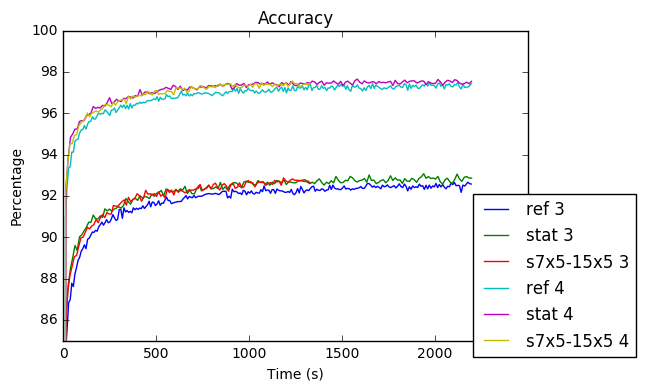

In [98]:
import matplotlib.pyplot as plt

plt.xlabel("Time (s)")
plt.ylabel("Percentage")
plt.title("Accuracy")

for i in range(3,5):
    plt.plot([pt[1] for pt in ref],[pt[i] for pt in ref],label = 'ref %s'%i)
    plt.plot([pt[1] for pt in stats],[pt[i] for pt in stats],label = 'stat %s'%i)
    plt.plot([pt[1] for pt in s7x5_15x5],[pt[i] for pt in s7x5_15x5],label = 's7x5-15x5 %s'%i)
  
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,85,100))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.show()

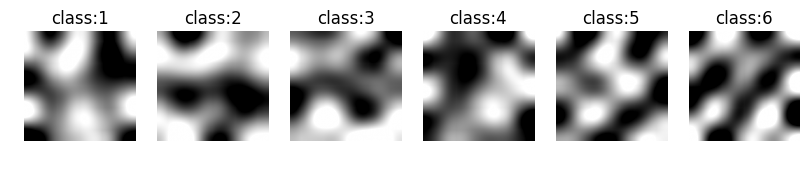

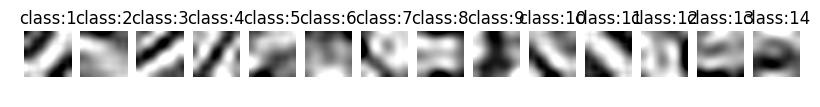

In [114]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
def plot(ww):
    fig = plt.figure()
    fig.set_size_inches(10, 2)
    ims = ww.shape[3]
    for i in range(0,ims):
        image = np.copy(ww[:,:,0,i])
        a = fig.add_subplot(1, ims, (i+1))
        a.set_title('class:%s' % (i+1))
        
        min = np.amin(image)
        max = np.amax(image)
        #image = (image-min)/(max-min)
        plt.imshow(-image,  cmap='gray',interpolation='sinc') #interpolation='none' cmap='gray',
        plt.axis('off')
    plt.show()
    

plot(conv_weights1)
plot(conv_weights2)


Accuracy: best networks around 97.5% on test set:
        
7x(7x7) + 15x(7x7) convolutions
        
[[0, 3.334742546081543, 14.84375, 15.03, 16.37]
 [200, 15.516491651535034, 89.0625, 86.2, 92.41]
 [400, 27.638538122177124, 89.453125, 87.7, 93.89]
 [600, 39.73741340637207, 90.234375, 88.5, 94.83]
 [800, 51.75591421127319, 89.0625, 89.02, 95.0]
 [1000, 63.79009127616882, 91.40625, 89.6, 95.23]
 [1200, 75.82052063941956, 91.796875, 89.36, 95.23]
 [1400, 87.8810772895813, 92.578125, 90.01, 95.6]
 [1600, 100.11754941940308, 89.84375, 90.11, 95.64]
 [1800, 112.42779541015625, 88.671875, 90.3, 95.64]
 [2000, 124.74626660346985, 91.015625, 90.47, 95.87]
 [2200, 137.1976718902588, 91.40625, 90.72, 95.92]
 [2400, 149.6706223487854, 91.796875, 90.72, 96.01]
 [2600, 162.11106252670288, 88.671875, 91.07, 96.32]
 [2800, 174.59564661979675, 92.96875, 90.89, 96.23]
 [3000, 187.02484440803528, 90.234375, 90.88, 96.28]
 [3200, 199.46576929092407, 92.1875, 91.03, 96.25]
 [3400, 211.9464340209961, 93.359375, 90.95, 96.38]
 [3600, 224.45464420318604, 92.1875, 91.37, 96.34]
 [3800, 236.89816880226135, 92.1875, 91.27, 96.51]
 [4000, 249.42860865592957, 91.40625, 91.36, 96.75]
 [4200, 262.0201427936554, 91.015625, 91.25, 96.46]
 [4400, 274.50421118736267, 92.96875, 91.36, 96.54]
 [4600, 287.14813566207886, 90.234375, 91.41, 96.67]
 [4800, 299.74577355384827, 89.453125, 91.47, 96.59]
 [5000, 312.33596539497375, 92.578125, 91.41, 96.56]
 [5200, 324.9380466938019, 92.578125, 91.54, 96.72]
 [5400, 337.5089056491852, 95.3125, 91.87, 96.7]
 [5600, 350.10735273361206, 93.359375, 91.71, 96.8]
 [5800, 362.68661236763, 95.3125, 91.6, 96.79]
 [6000, 375.37800312042236, 92.96875, 91.82, 96.73]
 [6200, 388.0139148235321, 92.578125, 91.88, 96.85]
 [6400, 400.7490563392639, 94.921875, 91.78, 96.82]
 [6600, 413.3192012310028, 93.359375, 92.01, 97.14]
 [6800, 425.96323227882385, 94.921875, 91.89, 96.86]
 [7000, 438.72986030578613, 94.140625, 91.97, 97.02]
 [7200, 451.5451691150665, 94.140625, 91.94, 97.02]
 [7400, 464.2570536136627, 92.96875, 91.87, 96.94]
 [7600, 476.83146381378174, 94.140625, 92.09, 97.0]
 [7800, 489.48943638801575, 93.75, 91.98, 96.94]
 [8000, 502.13784861564636, 92.96875, 92.12, 97.02]
 [8200, 514.7850558757782, 96.484375, 92.16, 97.1]
 [8400, 527.6258850097656, 94.53125, 92.26, 97.15]
 [8600, 540.3958067893982, 92.578125, 91.99, 97.17]
 [8800, 553.2550764083862, 94.140625, 92.33, 97.25]
 [9000, 566.0816440582275, 92.96875, 92.28, 97.2]
 [9200, 579.0756967067719, 92.578125, 92.21, 97.15]
 [9400, 591.7964267730713, 95.3125, 92.18, 97.35]
 [9600, 604.4651250839233, 96.875, 92.29, 97.29]
 [9800, 617.1483573913574, 91.40625, 92.22, 97.15]
 [10000, 629.8596317768097, 95.3125, 92.34, 97.31]
 [10200, 642.5291471481323, 95.3125, 92.28, 97.09]
 [10400, 655.2153298854828, 95.703125, 92.46, 97.16]
 [10600, 667.869485616684, 95.703125, 92.11, 97.12]
 [10800, 680.5334513187408, 94.140625, 92.27, 97.27]
 [11000, 693.2220408916473, 96.09375, 92.1, 97.24]
 [11200, 705.8724148273468, 93.359375, 92.1, 97.2]
 [11400, 718.5226972103119, 93.359375, 92.36, 97.13]
 [11600, 731.1790702342987, 94.921875, 92.51, 97.25]
 [11800, 743.8399047851562, 93.75, 92.24, 97.27]
 [12000, 756.5352306365967, 95.3125, 92.3, 97.28]
 [12200, 769.1930961608887, 95.703125, 92.39, 97.21]
 [12400, 782.0977053642273, 94.921875, 92.51, 97.34]
 [12600, 794.7711839675903, 95.3125, 92.35, 97.32]
 [12800, 807.4450986385345, 96.875, 92.35, 97.3]
 [13000, 820.1314465999603, 97.265625, 92.43, 97.33]
 [13200, 832.805212020874, 96.09375, 92.35, 97.32]
 [13400, 845.4692435264587, 96.09375, 92.65, 97.4]
 [13600, 858.1412434577942, 97.65625, 92.31, 97.31]
 [13800, 870.7999641895294, 94.921875, 92.44, 97.38]
 [14000, 883.4440467357635, 98.046875, 92.29, 97.44]
 [14200, 896.0811614990234, 95.3125, 92.52, 97.4]
 [14400, 908.7203538417816, 96.875, 92.54, 97.15]
 [14600, 921.4007608890533, 96.484375, 92.65, 97.24]
 [14800, 934.0531656742096, 98.046875, 92.61, 97.43]
 [15000, 946.7196016311646, 95.3125, 92.47, 97.35]
 [15200, 959.3747353553772, 98.4375, 92.4, 97.36]
 [15400, 972.0309023857117, 95.703125, 92.67, 97.44]
 [15600, 984.6853001117706, 96.09375, 92.71, 97.24]
 [15800, 997.3500726222992, 96.09375, 92.65, 97.38]
 [16000, 1009.9664993286133, 98.4375, 92.68, 97.38]
 [16200, 1022.607593536377, 95.3125, 92.54, 97.42]
 [16400, 1035.2626430988312, 96.484375, 92.53, 97.49]
 [16600, 1047.9160673618317, 95.3125, 92.74, 97.48]
 [16800, 1060.6295828819275, 95.703125, 92.65, 97.4]
 [17000, 1073.3210384845734, 95.703125, 92.69, 97.42]
 [17200, 1086.0152294635773, 96.875, 92.55, 97.41]
 [17400, 1098.6895005702972, 95.703125, 92.66, 97.51]
 [17600, 1111.3153471946716, 95.703125, 92.51, 97.39]
 [17800, 1123.9812076091766, 97.265625, 92.66, 97.47]
 [18000, 1136.6704986095428, 94.53125, 92.59, 97.4]
 [18200, 1149.2952914237976, 96.484375, 92.74, 97.37]
 [18400, 1161.958969116211, 98.4375, 92.7, 97.28]
 [18600, 1174.6169826984406, 97.65625, 92.64, 97.48]
 [18800, 1187.2785904407501, 97.265625, 92.76, 97.4]
 [19000, 1199.981122970581, 96.484375, 92.55, 97.48]
 [19200, 1212.678005695343, 95.703125, 92.67, 97.35]
 [19400, 1225.3452763557434, 96.484375, 92.66, 97.53]
 [19600, 1238.0316483974457, 98.4375, 92.63, 97.4]
 [19800, 1250.7007443904877, 96.09375, 92.63, 97.33]
 [20000, 1263.3799374103546, 97.265625, 92.72, 97.37]
 [20200, 1276.023922920227, 97.265625, 92.73, 97.46]
 [20400, 1288.696793794632, 96.09375, 92.76, 97.43]
 [20600, 1301.382644891739, 96.875, 92.78, 97.42]
 [20800, 1314.0083873271942, 98.046875, 92.65, 97.48]
 [21000, 1326.6590576171875, 97.65625, 92.59, 97.44]
 [21200, 1339.3947684764862, 97.265625, 92.66, 97.55]
 [21400, 1352.1234397888184, 95.3125, 92.59, 97.51]
 [21600, 1364.870786190033, 97.65625, 92.73, 97.39]
 [21800, 1377.6492807865143, 96.484375, 92.82, 97.49]
 [22000, 1390.4108593463898, 96.484375, 92.64, 97.55]
 [22200, 1403.178607225418, 98.046875, 92.52, 97.35]
 [22400, 1415.9203851222992, 98.046875, 92.66, 97.47]
 [22600, 1428.6611907482147, 97.265625, 92.59, 97.45]
 [22800, 1441.3758838176727, 96.875, 92.73, 97.46]
 [23000, 1454.0797288417816, 97.265625, 92.63, 97.56]
 [23200, 1466.8025012016296, 97.265625, 92.94, 97.47]
 [23400, 1479.506271123886, 97.265625, 92.76, 97.4]
 [23600, 1492.258154630661, 97.65625, 92.63, 97.54]
 [23800, 1505.0048320293427, 96.875, 92.65, 97.33]
 [24000, 1517.7455978393555, 96.875, 92.75, 97.5]
 [24200, 1530.504897594452, 97.265625, 92.73, 97.55]
 [24400, 1543.305023908615, 96.875, 92.94, 97.45]
 [24600, 1556.1120991706848, 97.265625, 92.87, 97.36]
 [24800, 1568.790355205536, 96.09375, 92.73, 97.57]
 [25000, 1581.483204126358, 98.046875, 92.67, 97.65]
 [25200, 1594.2938525676727, 98.046875, 92.74, 97.5]
 [25400, 1607.0183222293854, 98.4375, 92.76, 97.42]
 [25600, 1619.886870622635, 98.046875, 92.84, 97.56]
 [25800, 1632.5310707092285, 98.046875, 92.66, 97.48]
 [26000, 1645.2099788188934, 97.265625, 93.01, 97.46]
 [26200, 1658.0008037090302, 98.046875, 92.74, 97.51]
 [26400, 1670.7537853717804, 98.4375, 92.76, 97.52]
 [26600, 1683.6633658409119, 95.703125, 92.59, 97.42]
 [26800, 1696.4109964370728, 97.265625, 92.65, 97.53]
 [27000, 1709.1476187705994, 96.875, 92.74, 97.48]
 [27200, 1721.881887435913, 97.65625, 92.78, 97.49]
 [27400, 1734.6240093708038, 96.875, 92.63, 97.47]
 [27600, 1747.3700170516968, 98.046875, 92.75, 97.51]
 [27800, 1760.1104807853699, 98.828125, 92.97, 97.54]
 [28000, 1772.8871986865997, 98.4375, 92.74, 97.34]
 [28200, 1785.6325721740723, 98.828125, 92.87, 97.59]
 [28400, 1798.3772633075714, 99.21875, 92.76, 97.43]
 [28600, 1811.1156651973724, 96.875, 92.77, 97.41]
 [28800, 1823.8748083114624, 97.265625, 92.6, 97.51]
 [29000, 1836.6322045326233, 97.65625, 92.83, 97.6]
 [29200, 1849.3796586990356, 99.609375, 92.71, 97.47]
 [29400, 1862.1125779151917, 98.046875, 92.7, 97.54]
 [29600, 1874.8533051013947, 96.484375, 92.85, 97.56]
 [29800, 1887.590227842331, 98.046875, 92.78, 97.57]
 [30000, 1900.341061592102, 97.265625, 92.65, 97.46]
 [30200, 1913.1085093021393, 99.609375, 92.84, 97.5]
 [30400, 1925.8591032028198, 96.484375, 92.92, 97.56]
 [30600, 1938.6505088806152, 98.828125, 93.07, 97.55]
 [30800, 1951.4041986465454, 97.65625, 92.85, 97.38]
 [31000, 1964.1911273002625, 99.609375, 92.93, 97.53]
 [31200, 1976.9606764316559, 98.046875, 92.84, 97.45]
 [31400, 1989.7462272644043, 98.828125, 92.86, 97.43]
 [31600, 2002.4868113994598, 98.046875, 92.81, 97.45]
 [31800, 2015.2266781330109, 96.875, 92.94, 97.63]
 [32000, 2027.962616443634, 98.828125, 92.67, 97.52]
 [32200, 2040.7432487010956, 99.21875, 92.57, 97.35]
 [32400, 2053.4926402568817, 97.65625, 92.78, 97.5]
 [32600, 2066.2528216838837, 98.828125, 92.85, 97.59]
 [32800, 2079.161104440689, 97.265625, 92.68, 97.56]
 [33000, 2091.983781814575, 97.65625, 92.59, 97.48]
 [33200, 2105.0947737693787, 98.4375, 92.79, 97.62]
 [33400, 2118.0077135562897, 98.828125, 93.05, 97.58]
 [33600, 2130.872213602066, 100.0, 92.82, 97.46]
 [33800, 2143.963053703308, 96.875, 92.7, 97.4]
 [34000, 2156.67241191864, 98.828125, 92.9, 97.43]
 [34200, 2169.483793735504, 97.265625, 92.93, 97.5]
 [34400, 2182.5475351810455, 98.828125, 92.86, 97.42]
 [34600, 2195.7015244960785, 98.4375, 92.86, 97.54]]
